# Evaluation Testing

In [1]:
# Install necessary packages

import pandas as pd
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

import sklearn
import nltk

#!pip install weka
#!pip install gensim
#!pip install textblob
#import weka
#!pip install chainer
import gensim
from textblob import TextBlob

import json

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

In [3]:
# Get datasets and place into dataframes
# Attempt to read from local file first
# Read from url if impossible and then create local file for future use

columns = ["label", "comment", "author", "subreddit", "score", "ups", "downs", "date", "created_utc", "parent_comment"]

try:
    print("Reading from file...")
    test_balanced = pd.read_csv('data/test-balanced.csv.bz2', compression='bz2')
    train_balanced = pd.read_csv('data/train-balanced.csv.bz2', compression='bz2')
    print("Read successfully!")
except:
    print("No local file")
    print("Downloading...")
    test_balanced = pd.read_csv("http://nlp.cs.princeton.edu/SARC/1.0/main/test-balanced.csv.bz2", compression="bz2", sep="\t", header=None, names=columns)
    train_balanced = pd.read_csv("http://nlp.cs.princeton.edu/SARC/1.0/main/train-balanced.csv.bz2", compression="bz2", sep="\t", header=None, names=columns)
    print("Downloaded!")
    print("Creating local copy...")
    test_balanced.to_csv('data/test-balanced.csv.bz2', compression='bz2', index=False)
    train_balanced.to_csv('data/train-balanced.csv.bz2', compression='bz2', index=False)
    print("Local copy created successfully!")

Reading from file...
Read successfully!


In [4]:
data_types = {
    "label": "int",
    "comment": "unicode",
    "author": "unicode",
    "subreddit": "unicode",
    "score": "int",
    "ups": "int",
    "downs": "int",
    "date": "object",
    "created_utc": "object",
    "parent_comment": "unicode"
}

train_balanced = train_balanced.astype(data_types)
test_balanced = test_balanced.astype(data_types)

In [5]:
train_balanced['datetime'] = pd.to_datetime(train_balanced['created_utc'], unit='s')
test_balanced['datetime'] = pd.to_datetime(test_balanced['created_utc'], unit='s')

In [6]:
# So as not to run out of memory, only use a part of the dataset

#n_samples = 10000
#train = pd.concat((
#    train_balanced[train_balanced['label'] == 1].sample(n=int(n_samples/2)),
#    train_balanced[train_balanced['label'] == 0].sample(n=int(n_samples/2))
#)).sample(frac=1)
#test = pd.concat((
#    test_balanced[test_balanced['label'] == 1].sample(n=int(n_samples/8)),
#    test_balanced[test_balanced['label'] == 0].sample(n=int(n_samples/8))
#)).sample(frac=1)

train = train_balanced
test = test_balanced

In [7]:
train[train['score'] != train['ups']].head()

label                                            comment        author  \
0      0                                   Dang dog, thanks    Mattys1174   
1      0  to summon the powers of the flying spaghetti m...    yugiohhero   
2      0       i did that 3rd last 1 by accident last night    yugiohhero   
3      0  He's insane, used him in DC, better than Blake...  masternater6   
4      0  Forgot about him, he's a pretty pointless card...  masternater6   

         subreddit  score  ups  downs     date created_utc  \
0           NHLHUT      1   -1     -1  2017-03  1490927299   
1    CringeAnarchy      1   -1     -1  2017-02  1486349313   
2  TownofSalemgame      8   -1     -1  2017-03  1488514232   
3           NHLHUT      1   -1     -1  2017-02  1486097950   
4           NHLHUT      1   -1     -1  2017-04  1491597507   

                                      parent_comment            datetime  
0                             Great guess! Congrats! 2017-03-31 02:28:19  
1    can anynone explain what cash me outside means? 2017-02-06 02:48:33  
2                       I have seen all these things 2017-03-03 04:10:32  
3  ASG Weber review request Looking to pick him u... 2017-02-03 04:59:10  
4              Modano at least plays to his overall. 2017-04-07 20:38:27

# Model Preperation

In [8]:
# Tokenizer functions

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')

def tokenize(string):
    normalized_tokens = list()
    tokens = tokenizer.tokenize(string)
    for token in tokens:
        if (len(token) > 1):
            normalized = token.lower()
            normalized_tokens.append(normalized)
    return normalized_tokens

def stem_tokenizer(string):
    normalized_tokens = list()
    tokens = tokenizer.tokenize(string)
    for token in tokens:
        if len(token) > 1:
            normalized = token.lower()
            normalized = stemmer.stem(normalized)
            normalized_tokens.append(normalized)
    return normalized_tokens

def stop_tokenizer(string):
    normalized_tokens = list()
    tokens = tokenizer.tokenize(string)
    for token in tokens:
        if token.lower() not in stop_words and len(token) > 1:
            normalized = token.lower()
            normalized_tokens.append(normalized)
    return normalized_tokens

def stem_stop_tokenizer(string):
    normalized_tokens = list()
    tokens = tokenizer.tokenize(string)
    for token in tokens:
        if token.lower() not in stop_words and len(token) > 1:
            normalized = token.lower()
            normalized = stemmer.stem(normalized)
            normalized_tokens.append(normalized)
    return normalized_tokens

[nltk_data] Downloading package stopwords to /home/summer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# Evaluation function

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix

def eval_summary(name, predictions, labels):
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    print('\nConfusion matrix:\n',confusion_matrix(labels, predictions))
    print("Classifier '%s' has P=%0.3f R=%0.3f Acc=%0.3f F1=%0.3f" % (name, precision, recall, accuracy, f1))
    print(classification_report(labels, predictions))
    return f1

In [10]:
# Sklearn packages

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFE

In [11]:
# Handle other packages

from datetime import datetime, timedelta

from gensim.models.ldamodel import  LdaModel
from gensim.models import LdaMulticore
from gensim.corpora import Dictionary

from scipy.sparse import csr_matrix

from copy import deepcopy

from multiprocessing import Pool, cpu_count

nltk.download('punkt')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/summer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package tagsets to /home/summer/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/summer/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Feature Classes and Initializtion

In [12]:
all_data = train_balanced

In [13]:
# Prepare author sarcasm history dictionary with entire training dataset
try:
    print("Reading from file...")
    with open('models/author_history.json') as f:
        author_history = json.load(f)
        
except:
    print("No file present. Constructing...")
    author_history = {}

    today = all_data.sort_values(by=['datetime'], ascending=False).iloc[0]['datetime']
    last_week = today - timedelta(weeks=1)
    last_month = last_week - timedelta(weeks=4)
    last_six_months = last_month - timedelta(weeks=24)
    last_year = last_six_months - timedelta(days=365)

    zero_times = {
        'last_month': 0,
        'last_six_months': 0,
        'last_year': 0,
        'earlier': 0
    }

    for _, post in all_data.iterrows():
        if post['author'] not in author_history:
            author_history[post['author']] = {'0': zero_times.copy(), '1': zero_times.copy()}

        if (post['datetime'] >= last_month):
            time = 'last_month'
        elif (post['datetime'] >= last_six_months):# and post['datetime'] < self.last_week):
            time = 'last_six_months'
        elif (post['datetime'] >= last_year):# and post['datetime'] < self.last_month):
            time = 'last_year'
        else:
            time = 'earlier'

        author_history[post['author']][str(post['label'])][time] += 1
        
    with open('models/author_history.json', 'w') as f:
        json.dump(author_history, f)
        
print("Finished!")

Reading from file...
Finished!


In [14]:
try:
    print("Reading from file...")
    with open('models/subreddit_history.json') as f:
        subreddit_history = json.load(f)
        
except:
    print("No file present. Constructing...")
    subreddit_history = {}
    
    for _, post in all_data.iterrows():
        if post['subreddit'] not in subreddit_history:
            subreddit_history[post['subreddit']] = {'0': 0, '1': 1}
                
        subreddit_history[post['subreddit']][str(post['label'])] += 1
                
    with open('models/subreddit_history.json', 'w') as f:
        json.dump(subreddit_history, f)
        
print("Finished!")

Reading from file...
Finished!


In [15]:
try:
    print("Reading from file...")
    ldaModel = LdaModel.load('models/ldamodel.model')
    dictionary = Dictionary.load('models/dictionary.dict')
    
except:
    print("No file present. Constructing...")
    tokenized_text = all_data['comment'].apply(lambda comment: stem_stop_tokenizer(comment))
    dictionary = Dictionary(tokenized_text)
    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    ldaModel = LdaMulticore(
        corpus,
        num_topics=100,
        id2word=dictionary
    )
    
    ldaModel.save('models/ldamodel.model')
    dictionary.save('models/dictionary.dict')
    
print("Finished!")

Reading from file...
Finished!


In [16]:
#tokenized_text = all_data['comment'].apply(lambda comment: stem_stop_tokenizer(comment))
#dictionary = Dictionary(tokenized_text)
#corpus = [dictionary.doc2bow(text) for text in tokenized_text]

#ldaModel = LdaMulticore(
#    corpus,
#    num_topics=100,
#    id2word=dictionary
#)

In [17]:
try:
    print("Reading from file...")
    parent_ldaModel = LdaModel.load('models/parent_ldamodel.model')
    parent_dictionary = Dictionary.load('models/parent_dictionary.dict')
    
except:
    print("No file present. Constructing...")
    tokenized_text = all_data['parent_comment'].apply(lambda comment: tokenize(comment))
    parent_dictionary = Dictionary(tokenized_text)
    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    parent_ldaModel = LdaMulticore(
        corpus,
        num_topics=100,
        id2word=parent_dictionary
    )
    
    parent_ldaModel.save('models/parent_ldamodel.model')
    parent_dictionary.save('models/parent_dictionary.dict')
    
print("Finished!")

Reading from file...
Finished!


In [18]:
# Transformation classes
    
class Subreddit(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.sub_dict = {}
        
    def fit(self, X, y=None):
        i = 1
        for subreddit in X:
            if subreddit not in self.sub_dict:
                self.sub_dict[subreddit] = i
                i += 1
        return self
    
    def transform(self, X):
        return X.apply(lambda x: self.getSubCode(x))
    
    def getSubCode(self, subreddit):
        if subreddit in self.sub_dict:
            return self.sub_dict[subreddit]
        else:
            return 0
        
class SubredditSarcasm(BaseEstimator, TransformerMixin):
    def __init__(self, history=None, n_workers=None):
        self.history = history
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
            
        
    def fit(self, X, y=None):
        if (self.history == None):
            self.history = {}
            for _, post in X.iterrows():
                if post['subreddit'] not in self.history:
                    self.history[post['subreddit']] = {'0': 0, '1': 1}
                
                self.history[post['subreddit']][str(post['label'])] += 1
                    
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        sub_sarc = pool.map(self.getSarcasmHistory, X['subreddit'])
        pool.close()
        return sub_sarc
        #return X.apply(lambda x: self.getSarcasmHistory(x['subreddit']), axis=1)
    
    def getSarcasmHistory(self, subreddit):
        try:
            return(self.history[subreddit]['1'] / (self.history[subreddit]['0'] + self.history[subreddit]['1']))
        except:
            return 0.0
        
class AuthorSarcasm(BaseEstimator, TransformerMixin):
    def __init__(self, history=None, n_workers=None):
        self.history = history
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
        
    def fit(self, X, y=None):
        if (self.history == None):
            self.today = X.sort_values(by=['datetime'], ascending=False).iloc[0]['datetime']
            self.last_week = self.today - timedelta(weeks=1)
            self.last_month = self.last_week - timedelta(weeks=4)
            self.last_six_months = self.last_month - timedelta(weeks=24)
            self.last_year = self.last_six_months - timedelta(days=365)
            
            self.history = {}
            zero_times = {
                'last_month': 0,
                'last_six_months': 0,
                'last_year': 0,
                'earlier': 0
            }
            
            for _, post in X.iterrows():
                if post['author'] not in self.history:
                    self.history[post['author']] = {'0': zero_times.copy(), '1': zero_times.copy()}
                    
                if (post['datetime'] >= self.last_month):
                    time = 'last_month'
                elif (post['datetime'] >= self.last_six_months):
                    time = 'last_six_months'
                elif (post['datetime'] >= self.last_year):
                    time = 'last_year'
                else:
                    time = 'earlier'
                    
                self.history[post['author']][str(post['label'])][time] += 1
            
        return self
    
    def transform(self, X):  
        pool = Pool(self.n_workers)
        try:
            auth_sarc = pool.map(self.getAuthorSarcasmHistory, X['author'])
        except:
            pool.close()
        pool.close()
        return np.vstack(auth_sarc)
    
    def getAuthorSarcasmHistory(self, author):
        author_hist = np.zeros(4)
        for i, time in enumerate(['last_week', 'last_month', 'last_year', 'earlier']):
            try:
                author_hist[i] = float(
                    self.history[author]['1'][time] /
                    (self.history[author]['0'][time] + self.history[author]['1'][time])
                )
            except:
                author_hist[i] = 0.0
            
        return author_hist
    
class Polarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_workers=None):
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        polarity = pool.map(self.getPolarity, X)
        pool.close()
        return polarity
        #return X.apply(lambda comment: TextBlob(comment).sentiment.polarity)
        
    def getPolarity(self, comment):
        return TextBlob(comment).sentiment.polarity
    
class Subjectivity(BaseEstimator, TransformerMixin):
    def __init__(self, n_workers=None):
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        subjectivity = pool.map(self.getSubjectivity, X)
        pool.close()
        return subjectivity
        #return X.apply(lambda comment: TextBlob(comment).sentiment.polarity)
        
    def getSubjectivity(self, comment):
        return TextBlob(comment).sentiment.subjectivity
    
class SentimentDifference(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda x: self.getSentDiff(x))
    
    def getSentDiff(self, comment):
        blob = TextBlob(comment)
        sentences = blob.sentences
        
        if (len(sentences) == 1):
            words = blob.words
            l = len(words)
            first = words[:int(l/2)]
            second = words[int(l/2):]
            return abs(TextBlob(str(first)).polarity - TextBlob(str(second)).polarity)
        
        else:
            l = len(sentences)
            first = sentences[:int(l/2)]
            second = sentences[int(l/2):]
            return abs(
                np.mean([sentence.polarity for sentence in first]) -
                np.mean([sentence.polarity for sentence in second])
            )
        
class SentDiffPerSentence(BaseEstimator, TransformerMixin):
    def __init__(self, n_workers=None):
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        sent_diff = pool.map(self.getSentDiff, X)
        pool.close()
        return sent_diff
        #return X.apply(lambda comment: self.getSentDiff(comment))
    
    def getSentDiff(self, comment):
        sentences = TextBlob(comment).sentences
        diffs = np.zeros(len(sentences))
        
        for i, sentence in enumerate(sentences):
            words = sentence.words
            l = len(words)
            
            diffs[i] = abs(TextBlob(str(words[:int(l/2)])).polarity - TextBlob(str(words[int(l/2):])).polarity)
            
        return np.mean(diffs)
    
class TopicExtractor(BaseEstimator, TransformerMixin):
    '''Returns the most prominent topics for each document in the corpus'''
    def __init__(
        self,
        num_topics=100,
        display=False,
        minimum_probability=0.01,
        ldaModel=None,
        dictionary=None,
        alpha=1,
        tokenizer=stem_stop_tokenizer,
        n_workers=None
    ):
        self.num_topics = num_topics
        self.display = display
        self.minimum_probability = minimum_probability
        self.ldaModel = ldaModel
        self.dictionary = dictionary
        self.alpha = alpha
        self.tokenize = tokenizer
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
    
    def fit(self, X, y=None):
        if (self.ldaModel == None):
            self.display and print("Tokenizing coments...")
            tokenized_text = X.apply(lambda comment: self.tokenize(comment))
            self.display and print("Preparing dictionary...")
            self.dictionary = Dictionary(tokenized_text)
            self.display and print("Creating corpus...")
            corpus = [self.dictionary.doc2bow(text) for text in tokenized_text]

            self.display and print("Initializing LDA Model...")
            self.ldaModel = LdaMulticore(
                corpus,
                num_topics=self.num_topics,
                id2word=self.dictionary,
                alpha=self.alpha,
                minimum_probability=self.minimum_probability
            )

            self.display and print("Done!\n")
            if (self.display):
                for topics in self.ldaModel.print_topics():
                    print(topics)
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        topics = pool.map(self.getTopics, X)
        pool.close()
        return np.vstack(topics)
        
        #tokenized_text = X.apply(lambda comment: self.tokenize(comment))
        #corpus = [self.dictionary.doc2bow(text) for text in tokenized_text]
        #all_doc_topics = [self.ldaModel[doc] for doc in corpus]
        #
        #data = list()
        #rows = list()
        #cols = list()
        #for i, doc_topics in enumerate(all_doc_topics):
        #    for topic in doc_topics:
        #        data.append(topic[1])
        #        rows.append(i)
        #        cols.append(topic[0])
        #
        #return scipy.sparse.csr_matrix((data, (rows, cols)), shape=(len(corpus), self.num_topics))
    
    def getTopics(self, comment):
        topics = self.ldaModel.get_document_topics(
            self.dictionary.doc2bow(self.tokenize(comment)),
            minimum_probability = self.minimum_probability
        )
        #topics = self.ldaModel[self.dictionary.doc2bow(self.tokenize(comment))]
        
        topic_matrix = np.zeros(100)
        for topic in topics:
            topic_matrix[topic[0]] = topic[1]
            
        return topic_matrix
        
    
class PoSTags(BaseEstimator, TransformerMixin):
    def __init__(self, n_workers=None):
        # list of all PoS Tags
        all_tags = [
            '$', '\'\'', '(', ')', ',', '--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS',
            'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM',
            'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``', 'None'
        ]
        
        # dictionary mapping tags to index number
        self.tag_to_i = {}
        for i, tag in enumerate(all_tags):
            self.tag_to_i[tag] = i
            
        # number of workers for multithreading
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        pos = pool.map(self.getPoSTags, X)
        pool.close()
        return np.vstack(pos)
    
    def getPoSTags(self, comment):
        tokens = nltk.word_tokenize(comment) # split comment into tokens
        tags = nltk.pos_tag(tokens) # get each token's PoS tag
        pos = np.zeros(len(self.tag_to_i))
        
        # count number of occurrences of each tag
        for tag in tags:
            pos[self.tag_to_i[tag[1]]] += 1
        
        if (len(tokens) > 0):
            # normalize data - return percentage of words that are each tag
            return np.nan_to_num(pos / len(tokens))
        else:
            return pos
    
class PoSType(BaseEstimator, TransformerMixin):
    def __init__(self, tag):
        self.tag = tag
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.apply(lambda x: self.getTag(x))
    
    def getTag(self, comment):
        tokens = tokenize(comment)
        tags = nltk.pos_tag(tokens)
        n_interjections = 0
        
        for tag in tags:
            if (tag[1] == self.tag):
                n_interjections +=1
                
        try:
            return n_interjections / len(tokens)
        except:
            return 0
        
class N_sentences(BaseEstimator, TransformerMixin):
    def fit (self, X, y=None):
        return self
    
    def transform (self, X):
        return X.apply(lambda comment: len(TextBlob(comment).sentences))
    
class CommentLength(BaseEstimator, TransformerMixin):
    def __init__(self, term="character", n_workers=None):
        self.term = term
        if (n_workers == None):
            self.n_workers = cpu_count() -1
        else:
            self.n_workers = n_workers
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        lengths = pool.map(self.getLength, X)
        pool.close()
        return lengths
        
    def getLength(self, comment):
        if (self.term == "character"):
            return float(len(comment))
        elif (self.term == "word"):
            return float(len(TextBlob(comment).words))
        elif (self.term == "sentence"):
            return float(len(TextBlob(comment).sentences))

In [19]:
# Utility classes

class ColumnSelector(BaseEstimator, TransformerMixin):
    '''Returns a single column from a dataframe'''
    def __init__(self, column):
        self.column = column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.column]

class OneDReshaper(BaseEstimator, TransformerMixin):
    '''Converts a 1D array to a 2D array with one dimension 1 to fit scikit-learn transformers'''
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.values.reshape(-1, 1)
    
class ToArray(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.toarray()
    
class ToNpArray(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        arr = np.array(X)
        return arr.reshape(-1, 1)
    
class Printer(BaseEstimator, TransformerMixin):
    def __init__(self, n_rows=20):
        self.n_rows = n_rows
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print(X[:self.n_rows])
        print(X.shape)
        return X

In [20]:
# The seperate features

features = [
    ("n_grams", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('vect', TfidfVectorizer(binary=True, ngram_range=(1,2)))#, tokenizer=tokenize))
    ])),
    ("parent_n_grams", Pipeline([
        ('selector', ColumnSelector('parent_comment')),
        ('vect', TfidfVectorizer(binary=True, ngram_range=(1,2)))
    ])),
    ("score", Pipeline([
        ('selector', ColumnSelector('score')),
        ('reshape', OneDReshaper()),
    ])),
    ("comment_length", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('n_sentences', CommentLength(term='sentence')),
        ('reshape',ToNpArray())
    ])),
    ("subreddit_sarcasm", Pipeline([
        ('sarcasm', SubredditSarcasm(history=subreddit_history)),
        ('toarray', ToNpArray()),
    ])),
    ("author_sarcasm", Pipeline([
        ('sarcasm', AuthorSarcasm(history=author_history)),
        #('toarray', ToArray()),
    ])),
    ("polarity", Pipeline([
        ("selector", ColumnSelector("comment")),
        ('polarity', Polarity()),
        ('toarray', ToNpArray()),
    ])),
    ("subjectivity", Pipeline([
        ("selector", ColumnSelector("comment")),
        ('polarity', Subjectivity()),
        ('toarray', ToNpArray()),
    ])),
    ("sentiment_difference", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('difference', SentDiffPerSentence()),
        ('toarray', ToNpArray()),
        ('scale', StandardScaler())
    ])),
    ("topics", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('topics', TopicExtractor(ldaModel=ldaModel, dictionary=dictionary)),
    ])),
    ("parent_topics", Pipeline([
        ('selector', ColumnSelector('parent_comment')),
        ('topics', TopicExtractor(ldaModel=parent_ldaModel, dictionary=parent_dictionary))
    ])),
    ("pos_tags", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('pos_tags', PoSTags())
    ])),
]

features_that_work = [
    ("n_grams", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('vect', TfidfVectorizer(binary=True, ngram_range=(1,2), tokenizer=tokenize)),
    ])),
    ("parent_n_grams", Pipeline([
        ('selector', ColumnSelector('parent_comment')),
        ('vect', TfidfVectorizer(binary=True, ngram_range=(1,2)))
    ])),
    ("subreddit_sarcasm", Pipeline([
        ('sarcasm', SubredditSarcasm(history=subreddit_history)),
        ('toarray', ToNpArray()),
    ])),
    ("topics", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('topics', TopicExtractor(ldaModel=ldaModel, dictionary=dictionary)),
    ])),
    ("parent_topics", Pipeline([
        ('selector', ColumnSelector('parent_comment')),
        ('topics', TopicExtractor()),
    ])),
    ("pos_tags", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('pos_tags', PoSTags()),
    ]))
]

features_that_work2 = [
    ("n_grams", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('vect', TfidfVectorizer(binary=True, ngram_range=(1,2), tokenizer=tokenize)),
    ])),
    ("subreddit_sarcasm", Pipeline([
        ('sarcasm', SubredditSarcasm(history=subreddit_history)),
        ('reshape', OneDReshaper()),
    ])),
    ("sentiment_difference", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('difference', SentDiffPerSentence()),
        ('reshape', OneDReshaper()),
    ])),
    ("parent_topics", Pipeline([
        ('selector', ColumnSelector('parent_comment')),
        ('topics', TopicExtractor())
    ])),
]

# TSNE Reduction

In [52]:
feature_extractor = FeatureUnion(features)

In [53]:
feature_train = feature_extractor.fit_transform(train, train['label'])

Process ForkPoolWorker-26:
Process ForkPoolWorker-27:
Process ForkPoolWorker-25:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/dominic/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/dominic/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dominic/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dominic/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/dominic/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/dominic/anaconda3/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/home/dominic/anaconda3/lib/python3.6/multiprocessing/pro

KeyboardInterrupt: 

In [ ]:
feature_space = feature_extractor.transform(test)

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, learning_rate=50)
truncator = TruncatedSVD(n_components=50)

print("Features extracted - %dD vector space" % feature_space.shape[1])

truncated_feature_space = truncator.fit_transform(feature_space)
print("Features truncated - %dD vector space" % truncated_feature_space.shape[1])

tsne_space = tsne.fit_transform(truncated_feature_space)
print("TSNE applied       - %dD vector space" % tsne_space.shape[1])

In [ ]:
tsne_sarc = tsne_space[test['label'] == 1]
tsne_non_sarc = tsne_space[test['label'] == 0]

In [ ]:
plt.figure()
plt.scatter(tsne_sarc[:, 0], tsne_sarc[:, 1], c='orange', alpha=0.2, label="Sarcastic")
plt.scatter(tsne_non_sarc[:, 0], tsne_non_sarc[:, 1], c='blue', alpha=0.2, label="Non sarcastic")
plt.legend()
plt.title("TSNE Reduced Sarcastic Comments")

In [ ]:
main_clf = Pipeline([
    ('scale', MaxAbsScaler()),
    ('clf', LogisticRegression())
])
main_clf.fit(feature_train, train['label'])
eval_summary("LogReg", main_clf.predict(feature_space), test['label'])

In [ ]:
tsne_pred_sarc = tsne_space[main_clf.predict(feature_space) == 1]
tsne_pred_non_sarc = tsne_space[main_clf.predict(feature_space) == 0]

In [ ]:
plt.figure()
plt.scatter(tsne_pred_sarc[:, 0], tsne_pred_sarc[:, 1], c='orange', alpha=0.2, label="Sarcastic")
plt.scatter(tsne_pred_non_sarc[:, 0], tsne_pred_non_sarc[:, 1], c='blue', alpha=0.2, label="Non sarcastic")
plt.legend()
plt.title("TSNE Reduced Sarcastic Comments")

In [55]:
print(sys.getsizeof(feature_train))
print(sys.getsizeof(feature_test))
print(sys.getsizeof(main_clf))

NameError: name 'feature_train' is not defined

In [56]:
print(sys.getsizeof(train_balanced.iloc[:10000]))

5736205


# Feature Weighting

In [25]:
all_weights = main_clf.steps[1][1].coef_[0, :]
weight_args = np.flip(np.argsort(all_weights), axis=-1)

In [27]:
n_gram_vocab = feature_extractor.transformer_list[0][1].steps[1][1].vocabulary_
n_gram_len = len(n_gram_vocab)

parent_n_gram_vocab = feature_extractor.transformer_list[1][1].steps[1][1].vocabulary_
parent_n_gram_len = len(parent_n_gram_vocab)

all_n_len = n_gram_len + parent_n_gram_len

all_tags = [
    '$', '\'\'', '(', ')', ',', '--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS',
    'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM',
    'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``', 'None'
]
all_tag_names = [
    'dollar', 'closing quotation marks', 'opening parantheses', 'closing parantheses', 'comma', 'dash',
    'sentence terminator', 'colon or elipsis', 'conjunction, coordinating', 'numeral, cardinal', 'determiner',
    'exisensial there', 'foreign word', 'preposition or conjunction, subordinating', 'adjective or numeral, ordinal',
    'adjective, comparative', 'adjective, superlative', 'list item marker', 'modal auxiliary',
    'noun, common, singular or mass', 'noun, proper, singular', 'noun, proper, plural', 'noun, common, plural', 'pre-determiner',
    'genitive marker', 'pronoun, personal', 'pronoun, possessive', 'adverb', 'adverb, comparative',
    'adverb, superlative', 'particle', 'symbol', '"to" as preposition or infinitive marker', 'interjection',
    'verb, base form', 'verb, past tense', 'verb, present participle or gerund', 'verb, past participle',
    'verb, present tense, not 3rd person singular', 'verb, present tense, 3rd person singular', 'WH-determiner',
    'WH-pronoun', 'WH-pronoun, possessive', 'Wh-adverb', 'opening quotation mark', 'None'
]
pos_len = len(all_tags)

In [33]:
j = 0
for i, arg in enumerate(weight_args):
    if (arg >= all_n_len + 210):
        tag_index = arg - (all_n_len + 210)
        print("{}/{} - {} ({}): {}".format(j, i, all_tag_names[tag_index], all_tags[tag_index], all_weights[arg]))
        j += 1

0/32 - WH-pronoun (WP): 0.757358434864028
1/46 - modal auxiliary (MD): 0.6577931273565486
2/66 - verb, present tense, not 3rd person singular (VBP): 0.62109034157533
3/73 - pre-determiner (PDT): 0.6080062115332125
4/294 - verb, base form (VB): 0.42122890413290315
5/304 - conjunction, coordinating (CC): 0.41752405594305075
6/464 - verb, present tense, 3rd person singular (VBZ): 0.3741526073087782
7/903 - interjection (UH): 0.31223816970805773
8/3250 - adjective or numeral, ordinal (JJ): 0.2079731280544463
9/3857 - "to" as preposition or infinitive marker (TO): 0.1977818508853712
10/15283 - adverb, superlative (RBS): 0.12166727537366462
11/34278 - pronoun, personal (PRP): 0.08464542048618123
12/38100 - dollar ($): 0.07973528772233103
13/42032 - WH-determiner (WDT): 0.07485281558849066
14/62927 - WH-pronoun, possessive (WP$): 0.054797363913732404
15/88190 - verb, present participle or gerund (VBG): 0.035566550892372685
16/109581 - adverb, comparative (RBR): 0.005851362682350958
17/110244 

In [35]:
for i, arg in enumerate(weight_args[:100]):
    if (arg < n_gram_len): # n-grams
        for key in n_gram_vocab:
            if (n_gram_vocab[key] == arg):
                print("{}: (N-gram) {} - {}".format(i, key, all_weights[arg]))
                break
    elif (arg >= n_gram_len and arg < all_n_len): # parent n-grams
        for key in parent_n_gram_vocab:
            if (parent_n_gram_vocab[key] == arg):
                print("{}: (Parent N-gram) {} - {}".format(i, key, all_weights[arg]))
                break
    elif (arg == all_n_len): # score
        print("{}: Score - {}".format(i, all_weights[arg]))
    elif (arg == all_n_len + 1): # length
        print("{}: Length - {}".format(i, all_weights[arg]))
    elif (arg == all_n_len + 2): # sub sarc
        print("{}: Subreddit Sarcasm - {}".format(i, all_weights[arg]))
    elif (arg >= all_n_len + 3 and arg < all_n_len + 7): # author sarc
        auth_index = arg - (all_n_len + 3)
        if (auth_index == 0):
            print("{}: Author History (Last Month)- {}".format(i, all_weights[arg]))
        elif (auth_index == 1):
            print("{}: Author History (Last Six Months)- {}".format(i, all_weights[arg]))
        elif (auth_index == 2):
            print("{}: Author History (Last Year)- {}".format(i, all_weights[arg]))
        elif (auth_index == 3):
            print("{}: Author History (All time)- {}".format(i, all_weights[arg]))
    elif (arg == all_n_len + 7): # polarity
        print("{}: Polarity - {}".format(i, all_weights[arg]))
    elif (arg == all_n_len + 8): # subjectivity
        print("{}: Subjectivity - {}".format(i, all_weights[arg]))
    elif (arg == all_n_len + 9): # sent diff
        print("{}: Sentiment Difference - {}".format(i, all_weights[arg]))
    elif (arg >= all_n_len + 10 and arg < all_n_len + 110): # topics
        topic_index = arg - (all_n_len + 10)
        print("{}: Topic {} - {}\n\t{}".format(i, topic_index, all_weights[arg], ldaModel.print_topic(topic_index, topn=20)))
    elif (arg >= all_n_len + 110 and arg < all_n_len + 210): # parent topics
        topic_index = arg - (all_n_len + 110)
        print("{}: Parent Topic {} - {}\n\t{}".format(i, topic_index, all_weights[arg], parent_ldaModel.print_topic(topic_index, topn=20)))
    elif (arg >= all_n_len + 210): # pos tags
        tag_index = arg - (all_n_len + 210)
        print("{}: PoS Tag {} - {}".format(i, all_tags[tag_index], all_weights[arg]))

0: Subreddit Sarcasm - 4.304151545232594
1: (N-gram) because - 2.5357678918503677
2: (N-gram) clearly - 1.6546580609032262
3: Topic 23 - 1.5188861091140335
	0.191*"bad" + 0.160*"wow" + 0.121*"black" + 0.092*"racist" + 0.070*"heard" + 0.056*"ass" + 0.050*"bring" + 0.030*"provid" + 0.029*"worst" + 0.016*"pain" + 0.016*"zero" + 0.015*"ring" + 0.015*"hors" + 0.013*"punch" + 0.012*"celebr" + 0.011*"casual" + 0.010*"label" + 0.009*"weekend" + 0.008*"tabl" + 0.007*"filthi"
4: (N-gram) totally - 1.3268130154984223
5: (N-gram) yeah - 1.3181501208366972
6: (N-gram) but - 1.3167724192542505
7: (N-gram) all - 1.2578897568969043
8: Topic 55 - 1.1864005689145019
	0.597*"yeah" + 0.102*"live" + 0.059*"place" + 0.054*"tax" + 0.022*"current" + 0.020*"bullshit" + 0.020*"canada" + 0.015*"match" + 0.014*"honest" + 0.014*"retard" + 0.009*"microsoft" + 0.007*"retir" + 0.007*"info" + 0.007*"batteri" + 0.005*"consist" + 0.005*"edgi" + 0.005*"hockey" + 0.004*"butter" + 0.004*"sum" + 0.004*"expand"
9: (N-gram) y

65: Topic 80 - 0.6212591638004143
	0.337*"mean" + 0.092*"instead" + 0.083*"news" + 0.071*"suck" + 0.054*"expect" + 0.050*"mention" + 0.047*"listen" + 0.042*"fake" + 0.031*"fox" + 0.025*"hair" + 0.019*"stream" + 0.017*"biggest" + 0.015*"discrimin" + 0.013*"core" + 0.012*"knee" + 0.011*"climat" + 0.010*"pizza" + 0.008*"snap" + 0.006*"introduc" + 0.005*"heathen"
66: PoS Tag VBP - 0.62109034157533
67: (N-gram) important - 0.6208286111475549
68: (Parent N-gram) that mean - 0.6173143134115584
69: (N-gram) body - 0.6125180840754921
70: (Parent N-gram) whatnot - 0.6102969835811876
71: (Parent N-gram) number tattooed - 0.6095143083866421
73: PoS Tag PDT - 0.6080062115332125
74: (N-gram) water - 0.606404620370142
75: (N-gram) of course - 0.606286944417668
76: (Parent N-gram) orion going - 0.6057222173968431
77: Topic 17 - 0.6051513562497749
	0.480*"well" + 0.153*"ever" + 0.080*"seen" + 0.040*"death" + 0.035*"asshol" + 0.028*"wors" + 0.027*"ball" + 0.024*"given" + 0.015*"punish" + 0.014*"ridicul"

In [130]:
for i, arg in enumerate(np.flip(weight_args, axis=-1)[:100]):
    if (arg < n_gram_len): # n-grams
        for key in n_gram_vocab:
            if (n_gram_vocab[key] == arg):
                print("{}: (N-gram) {} - {}".format(i, key, all_weights[arg]))
                break
    elif (arg >= n_gram_len and arg < all_n_len): # parent n-grams
        for key in parent_n_gram_vocab:
            if (parent_n_gram_vocab[key] == arg):
                print("{}: (Parent N-gram) {} - {}".format(i, key, all_weights[arg]))
                break
    elif (arg == all_n_len): # score
        print("{}: Score - {}".format(i, all_weights[arg]))
    elif (arg == all_n_len + 1): # length
        print("{}: Length - {}".format(i, all_weights[arg]))
    elif (arg == all_n_len + 2): # sub sarc
        print("{}: Subreddit Sarcasm - {}".format(i, all_weights[arg]))
    elif (arg >= all_n_len + 3 and arg < all_n_len + 7): # author sarc
        auth_index = arg - (all_n_len + 3)
        if (auth_index == 0):
            print("{}: Author History (Last Month)- {}".format(i, all_weights[arg]))
        elif (auth_index == 1):
            print("{}: Author History (Last Six Months)- {}".format(i, all_weights[arg]))
        elif (auth_index == 2):
            print("{}: Author History (Last Year)- {}".format(i, all_weights[arg]))
        elif (auth_index == 3):
            print("{}: Author History (All time)- {}".format(i, all_weights[arg]))
    elif (arg == all_n_len + 7): # polarity
        print("{}: Polarity - {}".format(i, all_weights[arg]))
    elif (arg == all_n_len + 8): # subjectivity
        print("{}: Subjectivity - {}".format(i, all_weights[arg]))
    elif (arg == all_n_len + 9): # sent diff
        print("{}: Sentiment Difference - {}".format(i, all_weights[arg]))
    elif (arg >= all_n_len + 10 and arg < all_n_len + 110): # topics
        topic_index = arg - (all_n_len + 10)
        print("{}: Topic {} - {}\n\t{}".format(i, topic_index, all_weights[arg], ldaModel.print_topic(topic_index, topn=20)))
    elif (arg >= all_n_len + 110 and arg < all_n_len + 210): # parent topics
        topic_index = arg - (all_n_len + 110)
        print("{}: Parent Topic {} - {}\n\t{}".format(i, topic_index, all_weights[arg], parent_ldaModel.print_topic(topic_index, topn=20)))
    elif (arg >= all_n_len + 210): # pos tags
        tag_index = arg - (all_n_len + 210)
        print("{}: PoS Tag {} - {}".format(i, all_tags[tag_index], all_weights[arg]))

0: (N-gram) or - -1.4085974356531679
1: (N-gram) thanks - -0.9357980916919598
2: Length - -0.8564273663477001
3: (N-gram) right now - -0.8135840815811038
4: (N-gram) too - -0.7896904987238893
5: Topic 51 - -0.7636278067814505
	0.186*"hope" + 0.148*"less" + 0.097*"public" + 0.066*"hilari" + 0.035*"offici" + 0.031*"uk" + 0.029*"process" + 0.025*"creepi" + 0.024*"execut" + 0.023*"travel" + 0.022*"channel" + 0.022*"career" + 0.022*"grade" + 0.020*"cast" + 0.018*"poster" + 0.017*"former" + 0.017*"applic" + 0.017*"via" + 0.017*"impact" + 0.016*"rel"
6: (N-gram) is that - -0.7551546011100846
7: (N-gram) reference - -0.7347444748480371
8: (N-gram) very - -0.7237072258046584
10: (N-gram) happy - -0.7154587468495538
11: (N-gram) my - -0.7001422512779549
12: Parent Topic 41 - -0.6852939385955213
	0.148*"mg42" + 0.130*"version" + 0.063*"hit" + 0.056*"hillari" + 0.054*"gloriou" + 0.042*"plead" + 0.039*"distract" + 0.035*"slush" + 0.032*"young" + 0.031*"sync" + 0.030*"rise" + 0.029*"sub" + 0.025*"ro

# Tfidf Vectorization

In [97]:
#tfidf = TfidfVectorizer(binary=True, ngram_range=(1,2))
#tfidf = TfidfVectorizer(binary=True, ngram_range=(1,2), tokenizer=RegexpTokenizer(r'\w+').tokenize)
tfidf = TfidfVectorizer(binary=True, ngram_range=(1,2), tokenizer=tokenize)

tfidf_train = tfidf.fit_transform(train['comment'], train['label'])
tfidf_test = tfidf.transform(test['comment'])

In [98]:
tfidf_clf = LinearSVC(C=0.1)
tfidf_clf.fit(tfidf_train, train['label'])

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [99]:
eval_summary("Tfidfvectorization", tfidf_clf.predict(tfidf_test), test['label'])


Confusion matrix:
 [[834 416]
 [463 787]]
Classifier 'Tfidfvectorization' has P=0.654 R=0.630 Acc=0.648 F1=0.642
             precision    recall  f1-score   support

          0       0.64      0.67      0.65      1250
          1       0.65      0.63      0.64      1250

avg / total       0.65      0.65      0.65      2500



0.6416632694659601

In [100]:
tfidf_vocab = tfidf.vocabulary_
tfidf_weights = tfidf_clf.coef_[0, :]
tfidf_args = np.flip(np.argsort(tfidf_weights), axis=-1)

In [115]:
for i, arg in enumerate(tfidf_args[:100]):
    for key in tfidf_vocab:
        if (tfidf_vocab[key] == arg):
            print("%d: %s - %.3f" % (i, key, tfidf_weights[arg]))
            break

0: yeah - 1.761
1: because - 1.729
2: obviously - 1.371
3: totally - 1.228
4: clearly - 1.148
5: well - 1.019
6: sure - 0.882
7: so - 0.817
8: all - 0.815
9: we - 0.753
10: guys - 0.751
11: racist - 0.750
12: those - 0.745
13: just - 0.733
14: omg - 0.684
15: but - 0.651
16: yes because - 0.649
17: you know - 0.641
18: should - 0.636
19: oh - 0.633
20: but it - 0.623
21: wow - 0.605
22: real - 0.594
23: yea - 0.579
24: dare - 0.557
25: needs - 0.553
26: just like - 0.531
27: racism - 0.525
28: ya - 0.522
29: thing - 0.520
30: never - 0.520
31: must - 0.515
32: they should - 0.503
33: but but - 0.498
34: black - 0.497
35: they - 0.493
36: is so - 0.491
37: hey - 0.486
38: guns - 0.483
39: must be - 0.483
40: our - 0.482
41: yay - 0.478
42: what about - 0.466
43: don you - 0.462
44: he - 0.455
45: it not - 0.451
46: white - 0.451
47: another - 0.450
48: guess - 0.447
49: obama - 0.446
50: course - 0.445
51: how dare - 0.445
52: wait - 0.435
53: rights - 0.431
54: stop - 0.425
55: great -

In [ ]:
for arg in np.flip(tfidf_args, axis=0)[:20]:
    for key in tfidf_vocab:
        if (tfidf_vocab[key] == arg):
            print("%s: %.3f" % (key, tfidf_weights[arg]))
            break

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, learning_rate=50)
truncator = TruncatedSVD(n_components=50)

tfidf_tsne = tsne.fit_transform(truncator.fit_transform(tfidf_test.toarray()))
tfidf_sarc = tfidf_tsne[test['label'] == 1]
tfidf_non_sarc = tfidf_tsne[test['label'] == 0]

In [ ]:
plt.figure()
plt.scatter(tfidf_sarc[:, 0], tfidf_sarc[:, 1], c='orange', alpha=0.5, label="Sarcastic")
plt.scatter(tfidf_non_sarc[:, 0], tfidf_non_sarc[:, 1], c='blue', alpha=0.5, label="Non Sarcastic")
plt.legend()
plt.title("TSNE Reduced Tfidf Vectorization")

# Non n-gram Features

In [ ]:
non_n_gram = FeatureUnion(features_that_work[1:].copy())
non_n_clf = LinearSVC(C=0.1)

In [ ]:
non_n_docs = non_n_gram.fit_transform(train, train['label'])
non_n_clf.fit(non_n_docs, train['label'])

In [ ]:
non_n_test = non_n_gram.transform(test)
eval_summary("Non n-gram features", non_n_clf.predict(non_n_test), test['label'])

In [ ]:
tsne = TSNE(n_components=2)
truncator = TruncatedSVD(n_components=50)

non_n_tsne = tsne.fit_transform(truncator.fit_transform(non_n_test))

In [ ]:
non_n_sarc = non_n_tsne[test['label'] == 1]
non_n_non_sarc = non_n_tsne[test['label'] == 0]

In [ ]:
plt.figure()
plt.scatter(non_n_sarc[:, 0], non_n_sarc[:, 1], c='orange', alpha=0.5, label="Sarcastic")
plt.scatter(non_n_non_sarc[:, 0], non_n_non_sarc[:, 1], c='blue', alpha=0.3, label="Non-Sarcastic")
plt.legend()
plt.title("Non n-gram features TSNE reduced")

# Single Column Feature Correlation

In [ ]:
single_features = [
    ("score", Pipeline([
        ('selector', ColumnSelector('score')),
        ('reshape', OneDReshaper()),
        ('scale', StandardScaler())
    ])),
    ("ups", Pipeline([
        ('selector', ColumnSelector('ups')),
        ('reshape', OneDReshaper()),
        ('scale', StandardScaler())
    ])),
    ("downs", Pipeline([
        ('selector', ColumnSelector('downs')),
        ('reshape', OneDReshaper()),
        ('scale', StandardScaler())
    ])),
    ("subreddit_sarcasm", Pipeline([
        ('sarcasm', SubredditSarcasm(history=subreddit_history)),
        ('toarray', ToNpArray()),
    ])),
    #("author_sarcasm", Pipeline([
    #    ('sarcasm', AuthorSarcasm(history=author_history)),
    #    ('reshape', OneDReshaper()),
    #])),
    ("polarity", Pipeline([
        ("selector", ColumnSelector("comment")),
        ('polarity', Polarity()),
        ('toarray', ToNpArray()),
    ])),
    ("subjectivity", Pipeline([
        ("selector", ColumnSelector("comment")),
        ('polarity', Subjectivity()),
        ('toarray', ToNpArray()),
    ])),
    ("sentiment_difference", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('difference', SentDiffPerSentence()),
        ('toarray', ToNpArray()),
        ('scaler', StandardScaler())
    ])),
    ('interjections', Pipeline([
        ('selector', ColumnSelector('comment')),
        ('pos_tag', PoSType('UH')),
        ('reshape', OneDReshaper())
    ])),
    ('proper_nouns', Pipeline([
        ('selector', ColumnSelector('comment')),
        ('pos_tag', PoSType('NNP')),
        ('reshape', OneDReshaper())
    ])),
    ('adverbs', Pipeline([
        ('selector', ColumnSelector('comment')),
        ('pos_tag', PoSType('RBR')),
        ('reshape', OneDReshaper())
    ])),
    ('n_sentences', Pipeline([
        ('selector', ColumnSelector('comment')),
        ('n_sentences', N_sentences()),
        ('reshape', OneDReshaper())
    ])),
]

In [ ]:
single_features_extractor = FeatureUnion(single_features)

In [ ]:
single_feature_train = single_features_extractor.fit_transform(train, train['label'])
single_feature_space = single_features_extractor.transform(test)

In [ ]:
labels = np.array(test['label']).reshape(-1,1)

In [ ]:
single_cor_df = pd.DataFrame(data=np.concatenate((labels, single_feature_space), axis=1))

In [ ]:
single_corr = single_cor_df.corr()
print(single_corr)

In [ ]:
feature_names = np.concatenate((["label"], [feature[0] for feature in single_features]))

plt.matshow(single_corr, vmin=-1, vmax=1)
#plt.xticks(range(len(feature_names)), feature_names, rotation='vertical')
plt.yticks(range(len(feature_names)), feature_names)
plt.colorbar()
plt.title("Correlation of Single Column Features", pad=12)

In [ ]:
single_clf = LinearSVC()
single_clf.fit(single_feature_train, train['label'])

In [ ]:
for name, weight in zip(feature_names[1:], single_clf.coef_[0]):
    print("%s: %.2f" % (name, weight))

# Sentiment

In [119]:
pol = Pipeline([
    ('selector', ColumnSelector('comment')),
    ('polarity', Polarity()),
    ('reshape', ToNpArray())
])

sarc_sents = pol.transform(train[train['label'] == 1])
non_sarc_sents = pol.transform(train[train['label'] == 0])

In [120]:
print("Mean sarcasrtic polarity: {}".format(np.mean(sarc_sents)))
print("Mean non-sarcasrtic polarity: {}".format(np.mean(non_sarc_sents)))

Mean sarcasrtic polarity: 0.06649805201848417
Mean non-sarcasrtic polarity: 0.062056370904558414


# Topic Correlation

In [21]:
topic_extractor = TopicExtractor(ldaModel=ldaModel, dictionary=dictionary, display=True, minimum_probability=0.1)

In [22]:
#train_topics = topic_extractor.fit_transform(train['comment'], train['label'])
test_topics = topic_extractor.transform(test['comment'])

In [23]:
labels = np.array(test['label']).reshape(-1,1)
cor_df = pd.DataFrame(data=np.concatenate((labels, test_topics), axis=1))
cor = cor_df.corr()

<IPython.core.display.Javascript object>


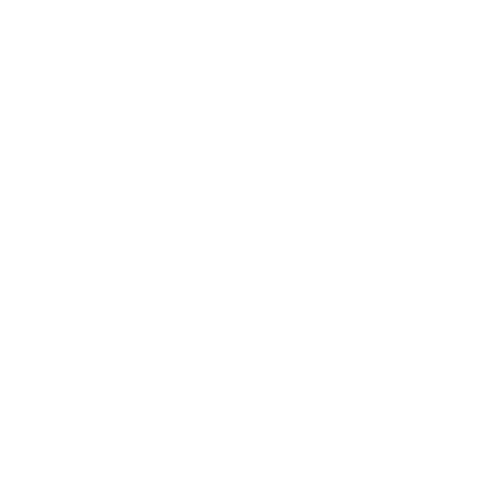

Text(0.5,1.05,'Topics Correlation')

In [29]:
plt.matshow(cor, vmin=-1, vmax=1)
plt.colorbar()
plt.title("Topics Correlation", pad=12)

In [31]:
sarc_test_topics = topic_extractor.transform((test[test['label'] == 1]['comment']))

AttributeError: 'Series' object has no attribute 'reshape'

In [41]:
sarc_cor = pd.DataFrame(data=sarc_test_topics).corr()

<IPython.core.display.Javascript object>


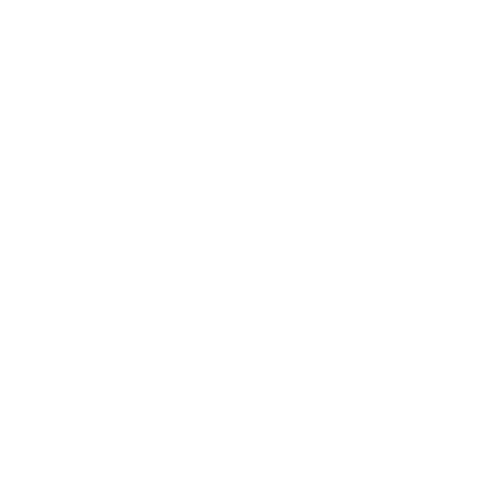

Text(0.5,1.05,'Topics Correlation for Sarcastic Comments')

In [44]:
plt.matshow(sarc_cor, vmin=-1, vmax=1)
plt.colorbar()
plt.title("Topics Correlation for Sarcastic Comments", pad=18)

In [135]:
counts = np.zeros(11)

for index, n in np.ndenumerate(cor):
    if (abs(n) >= 0.0 and abs(n) < 0.01):
        counts[0] += 1
    elif (abs(n) >= 0.01 and abs(n) < 0.02):
        counts[1] += 1
    elif (abs(n) >= 0.02 and abs(n) < 0.03):
        counts[2] += 1
    elif (abs(n) >= 0.03 and abs(n) < 0.04):
        counts[3] += 1
    elif (abs(n) >= 0.04 and abs(n) < 0.05):
        counts[4] += 1
    elif (abs(n) >= 0.05 and abs(n) < 0.06):
        counts[5] += 1
    elif (abs(n) >= 0.06 and abs(n) < 0.07):
        counts[6] += 1
    elif (abs(n) >= 0.07 and abs(n) < 0.08):
        counts[7] += 1
    elif (abs(n) >= 0.08 and abs(n) < 0.09):
        counts[8] += 1
    elif (abs(n) >= 0.09 and abs(n) < 0.1):
        counts[9] += 1
    elif (abs(n) >= 0.1 and abs(n) < 1.0):
        counts[10] += 1
        
cats = ["< 0.01", "< 0.02", "< 0.03", "< 0.04", "< 0.05", "< 0.06", "< 0.07", "< 0.08", "< 0.09", "< 0.1", "< 1.0"]

print("Counts for ranges in correlation matrix:")
for cat, count in zip(cats, counts):
    print("%s: %d" % (cat, count/2))

Counts for ranges in correlation matrix:
< 0.01: 1877
< 0.02: 1985
< 0.03: 957
< 0.04: 171
< 0.05: 40
< 0.06: 10
< 0.07: 5
< 0.08: 4
< 0.09: 0
< 0.1: 1
< 1.0: 0


In [136]:
for i, row in enumerate(np.array(cor)):
    for j, n in enumerate(row[i+1:]):
        if (abs(n) >= 0.1):
            print(i, "-", ldaModel.print_topic(i))
            print(j, "-", ldaModel.print_topic(j))
            print("\n")

In [137]:
non_zero_topics = np.zeros(test_topics.shape[0])

for i, topics in enumerate(test_topics):
    non_zero_topics[i] = np.count_nonzero(topics)
    
print("Mean number of non-zero topics:", np.mean(non_zero_topics))

Mean number of non-zero topics: 3.9896


In [138]:
topics_clf = LinearSVC(C=0.1)
topics_clf.fit(train_topics, train['label'])

LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [139]:
eval_summary('Topics', topics_clf.predict(test_topics), test['label'])


Confusion matrix:
 [[762 488]
 [588 662]]
Classifier 'Topics' has P=0.576 R=0.530 Acc=0.570 F1=0.552
             precision    recall  f1-score   support

          0       0.56      0.61      0.59      1250
          1       0.58      0.53      0.55      1250

avg / total       0.57      0.57      0.57      2500



0.5516666666666666

In [140]:
topic_weights = topics_clf.coef_[0, :]
topic_args = np.flip(np.argsort(topic_weights), axis=-1)

i = 0
for arg in topic_args[:10]:
    print("Topic %d - Local Weight: %f: - Big Weight: %f" % (arg, topic_weights[arg], all_weights[arg+all_n_len+10]))
    print(topic_extractor.ldaModel.print_topic(arg), "\n")
    if (i == 0):
        arg_1 = arg
    elif (i == 1):
        arg_2 = arg
    i += 1

Topic 55 - Local Weight: 1.200308: - Big Weight: 1.445815
0.597*"yeah" + 0.102*"live" + 0.059*"place" + 0.054*"tax" + 0.022*"current" + 0.020*"bullshit" + 0.020*"canada" + 0.015*"match" + 0.014*"honest" + 0.014*"retard" 

Topic 3 - Local Weight: 1.185113: - Big Weight: 1.447471
0.175*"clearli" + 0.106*"obama" + 0.103*"exactli" + 0.076*"mind" + 0.048*"deserv" + 0.043*"lose" + 0.040*"karma" + 0.040*"cat" + 0.035*"usual" + 0.034*"knew" 

Topic 23 - Local Weight: 1.001959: - Big Weight: 0.980136
0.191*"bad" + 0.160*"wow" + 0.121*"black" + 0.092*"racist" + 0.070*"heard" + 0.056*"ass" + 0.050*"bring" + 0.030*"provid" + 0.029*"worst" + 0.016*"pain" 

Topic 96 - Local Weight: 0.942734: - Big Weight: 0.827374
0.516*"sure" + 0.058*"dont" + 0.057*"dare" + 0.049*"minut" + 0.040*"idiot" + 0.040*"three" + 0.036*"facebook" + 0.035*"pro" + 0.028*"spell" + 0.020*"ton" 

Topic 19 - Local Weight: 0.831838: - Big Weight: 0.975661
0.285*"total" + 0.081*"abl" + 0.062*"wear" + 0.062*"non" + 0.052*"inform" + 

In [141]:
tsne = TSNE(n_components=2)
truncator = TruncatedSVD(n_components=50)

tsne_topics = tsne.fit_transform(truncator.fit_transform(test_topics))

In [142]:
sarc_topics = tsne_topics[test['label'] == 1]
non_sarc_topics = tsne_topics[test['label'] == 0]

<IPython.core.display.Javascript object>


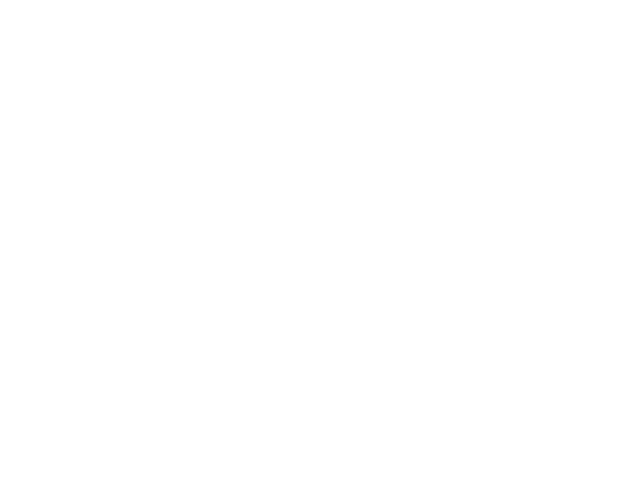

Text(0.5,1,'TSNE Reduced Topics')

In [143]:
plt.figure()
plt.scatter(sarc_topics[:, 0], sarc_topics[:, 1], c='orange', alpha=0.5, label="Sarcastic")
plt.scatter(non_sarc_topics[:, 0], non_sarc_topics[:, 1], c='blue', alpha=0.5, label="Non-sarcastic")
plt.legend()
plt.title("TSNE Reduced Topics")

# POS Tags

In [83]:
all_tags = [
    '$', '\'\'', '(', ')', ',', '--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS',
    'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM',
    'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``', 'None'
]

all_tag_names = [
    'dollar', 'closing quotation marks', 'opening parantheses', 'closing parantheses', 'comma', 'dash',
    'sentence terminator', 'colon or elipsis', 'conjunction, coordinating', 'numeral, cardinal', 'determiner',
    'exisensial there', 'foreign word', 'preposition or conjunction, subordinating', 'adjective or numeral, ordinal',
    'adjective, comparative', 'adjective, superlative', 'list item marker', 'modal auxiliary',
    'noun, common, singular or mass', 'noun, proper, singular', 'noun, proper, plural', 'noun, common, plural', 'pre-determiner',
    'genitive marker', 'pronoun, personal', 'pronoun, possessive', 'adverb', 'adverb, comparative',
    'adverb, superlative', 'particle', 'symbol', '"to" as preposition or infinitive marker', 'interjection',
    'verb, base form', 'verb, past tense', 'verb, present participle or gerund', 'verb, past participle',
    'verb, present tense, not 3rd person singular', 'verb, present tense, 3rd person singular', 'WH-determiner',
    'WH-pronoun', 'WH-pronoun, possessive', 'Wh-adverb', 'opening quotation mark', 'None'
]

In [84]:
pos = Pipeline([
    ('selector', ColumnSelector('comment')),
    ('pos_tags', PoSTags())
])

In [85]:
pos_train = pos.fit_transform(train, train['label'])
pos_test = pos.transform(test)

In [87]:
pos_corr = pd.DataFrame(np.concatenate((labels, pos_test), axis=1)).corr()

<IPython.core.display.Javascript object>


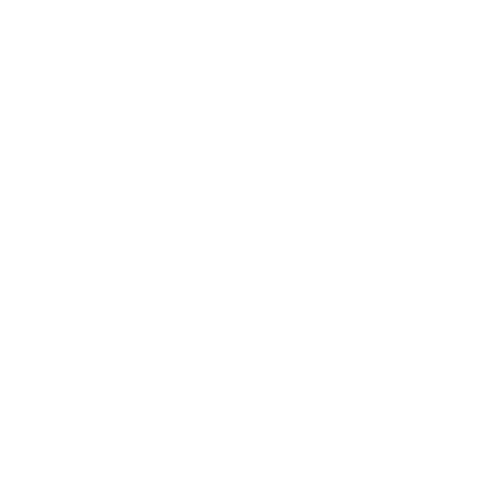

Text(0.5,1.05,'Prevalance of POS Tags Correlated')

In [88]:
plt.matshow(pos_corr, vmin=-1, vmax=1)
plt.colorbar()
plt.title("Prevalance of POS Tags Correlated", pad=12)

In [90]:
print("Strongly Correlated PoS Tags:")
for i, row in enumerate(np.array(pos_corr)):
    for j, c in enumerate(row[(i+1):]):
        if (abs(c) > 0.3):
            print("%s, %s: %.2f" % (all_tags[i], all_tags[j+i+1], c))

Strongly Correlated PoS Tags:
NN, VBD: 0.42
UH, VBD: 0.37


In [91]:
pos_clf = LinearSVC()
pos_clf.fit(pos_train, train['label'])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [92]:
eval_summary("POS Test", pos_clf.predict(pos_test), test['label'])


Confusion matrix:
 [[594 656]
 [516 734]]
Classifier 'POS Test' has P=0.528 R=0.587 Acc=0.531 F1=0.556
             precision    recall  f1-score   support

          0       0.54      0.48      0.50      1250
          1       0.53      0.59      0.56      1250

avg / total       0.53      0.53      0.53      2500



0.5560606060606061

In [93]:
pos_weights = pos_clf.coef_[0, :]
pos_args = np.flip(np.argsort(pos_weights), axis=-1)

for arg in pos_args:
    print("%s (%s): %.2f" % (all_tags[arg], pos_weights[arg]))

UH: 1.20
MD: 1.04
VBP: 1.02
PDT: 1.00
JJR: 0.93
JJS: 0.89
RB: 0.80
VBZ: 0.77
JJ: 0.70
CC: 0.65
WDT: 0.61
VBN: 0.59
PRP: 0.59
PRP$: 0.54
DT: 0.50
VBG: 0.47
IN: 0.45
TO: 0.42
WP: 0.41
VB: 0.34
NNS: 0.28
VBD: 0.26
NN: 0.23
EX: 0.21
WRB: 0.19
FW: 0.15
$: 0.10
RBR: 0.06
None: 0.00
): 0.00
'': 0.00
``: 0.00
POS: 0.00
(: 0.00
SYM: 0.00
LS: 0.00
:: 0.00
.: 0.00
--: 0.00
,: 0.00
RBS: -0.06
WP$: -0.13
CD: -0.13
NNP: -0.21
NNPS: -0.39
RP: -0.51


In [94]:
nltk.help.upenn_tagset()

$: dollar
    $ -$ --$ A$ C$ HK$ M$ NZ$ S$ U.S.$ US$
'': closing quotation mark
    ' ''
(: opening parenthesis
    ( [ {
): closing parenthesis
    ) ] }
,: comma
    ,
--: dash
    --
.: sentence terminator
    . ! ?
:: colon or ellipsis
    : ; ...
CC: conjunction, coordinating
    & 'n and both but either et for less minus neither nor or plus so
    therefore times v. versus vs. whether yet
CD: numeral, cardinal
    mid-1890 nine-thirty forty-two one-tenth ten million 0.5 one forty-
    seven 1987 twenty '79 zero two 78-degrees eighty-four IX '60s .025
    fifteen 271,124 dozen quintillion DM2,000 ...
DT: determiner
    all an another any both del each either every half la many much nary
    neither no some such that the them these this those
EX: existential there
    there
FW: foreign word
    gemeinschaft hund ich jeux habeas Haementeria Herr K'ang-si vous
    lutihaw alai je jour objets salutaris fille quibusdam pas trop Monte
    terram fiche oui corporis ...
IN: preposition or

# Different Subreddits

In [21]:
sub_sarc = SubredditSarcasm(history=subreddit_history)
#unique_subs = pd.concat((train_balanced, test_balanced)).drop_duplicates(subset='subreddit')
unique_subs = pd.concat((train, test)).drop_duplicates(subset='subreddit')
print(unique_subs.shape[0], "unique subreddits")

2090 unique subreddits


In [22]:
sub_sarcasm = np.array(sub_sarc.transform(unique_subs))

In [23]:
i = c = 0
for _, sub in unique_subs['subreddit'].iteritems():
    if (sub_sarcasm[i] > 0.9):
        print("%s: %.2f" % (sub, sub_sarcasm[i]))
        c += 1
    i += 1
    if (c > 20):
        break

asklaw: 1.00
LogHorizon: 1.00
ReversalReborn: 1.00
Mafia: 1.00
worldproblems: 1.00
typewriters: 1.00
NSALeaks: 1.00
gothsluts: 1.00
Delco: 1.00
Pacifism: 1.00
HAESSuccessStories: 1.00
Mordhau: 1.00
Friendzone: 1.00
techsnap: 1.00
u_Tnomad: 1.00
mississippi: 0.93
ColumbusBeer: 1.00
uhccirclejerk: 1.00
austinfood: 1.00
SpecArt: 1.00
Bozeman: 1.00


In [24]:
i = c = 0
for _, sub in unique_subs['subreddit'].iteritems():
    if (sub_sarcasm[i] < 0.1):
        print("%s: %.2f" % (sub, sub_sarcasm[i]))
        c += 1
    i += 1
    if (c > 20):
        break

GuessTheMovie: 0.05
Sneks: 0.08
Braveryjerk: 0.09
AskOuija: 0.03
Pokemongiveaway: 0.03
Fireteams: 0.04
lebowski: 0.06
Diablo3Wizards: 0.09
shittyadviceanimals: 0.06
ledootgeneration: 0.06
Rabbits: 0.08
onewordeach: 0.01
acturnips: 0.08
friendsafari: 0.03
MumenRider: 0.00
deadofwinter: 0.00
EliteWings: 0.00
pokemontrades: 0.08
TsundereImperialists: 0.00
R4R30Plus: 0.00
TrueSTL: 0.06


In [36]:
subs = pd.concat((train_balanced, test_balanced)).groupby(by='subreddit')

subs_sorted = list()
subs_sizes = list()
for sub, size in zip(subs.groups, subs.size()):
    subs_sorted.append(sub)
    subs_sizes.append(size)
    
sub_args = np.flip(np.argsort(subs_sizes), axis=0)

## Subreddit Topic Correlation

AskReddit - 88439 comments - 0.01971980687253361 sarcastic


<IPython.core.display.Javascript object>


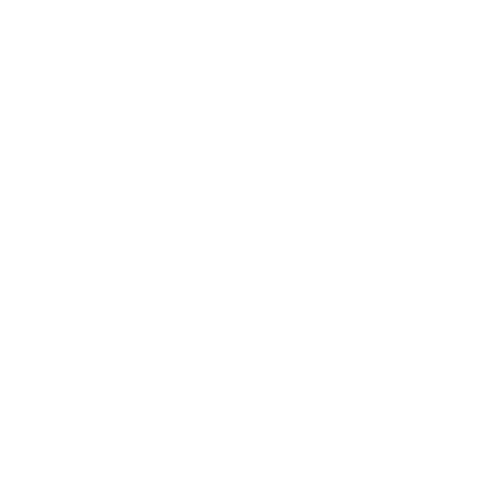



politics - 58803 comments - 0.04928319983674302 sarcastic


<IPython.core.display.Javascript object>


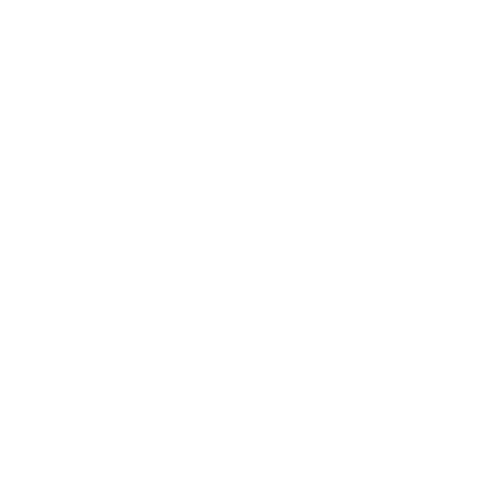



worldnews - 34929 comments - 0.08669014286123279 sarcastic


<IPython.core.display.Javascript object>


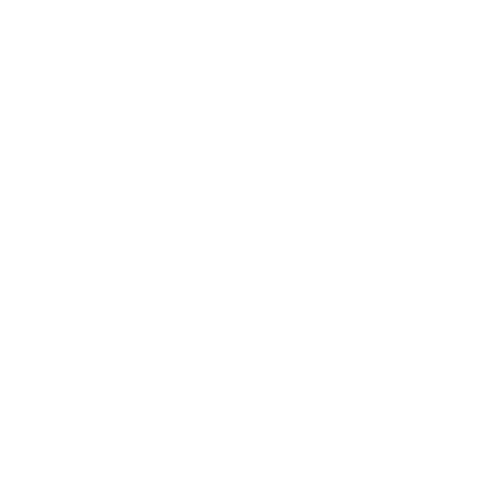



leagueoflegends - 26585 comments - 0.08941132217415836 sarcastic


<IPython.core.display.Javascript object>


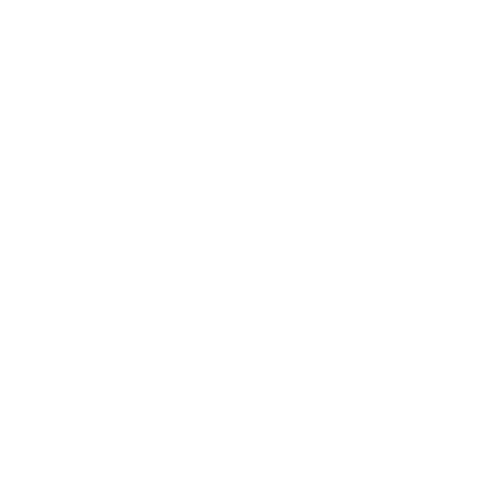



pcmasterrace - 24467 comments - 0.10442637021293988 sarcastic


<IPython.core.display.Javascript object>


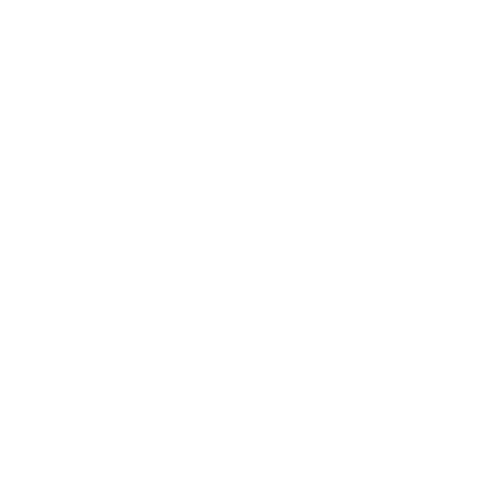



news - 23142 comments - 0.12047359778757238 sarcastic


<IPython.core.display.Javascript object>


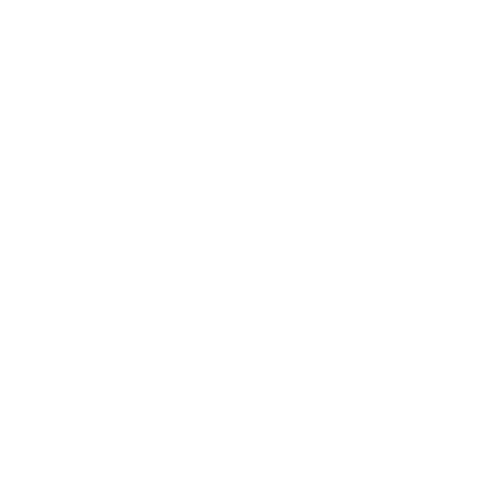



funny - 22890 comments - 0.08645696810834426 sarcastic


<IPython.core.display.Javascript object>


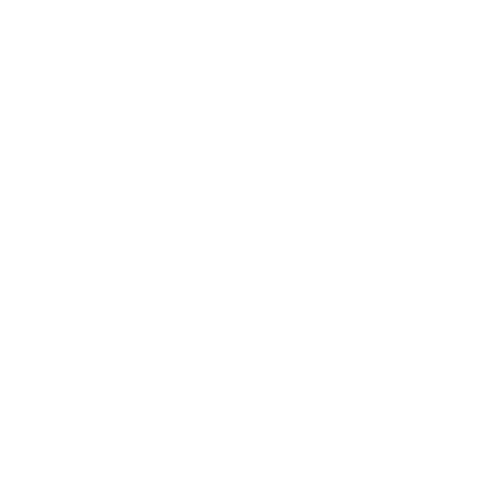



pics - 21104 comments - 0.11760803639120546 sarcastic


<IPython.core.display.Javascript object>


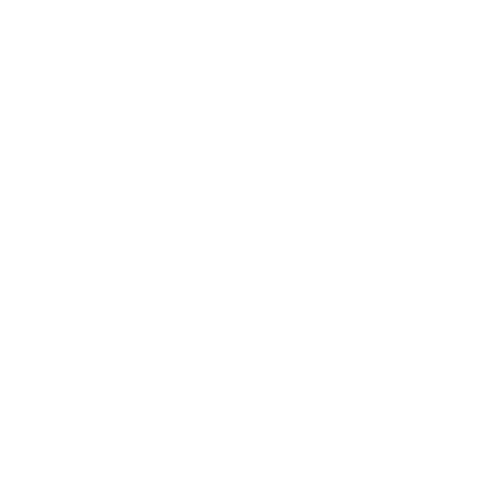



nba - 20779 comments - 0.10958178930651138 sarcastic


<IPython.core.display.Javascript object>


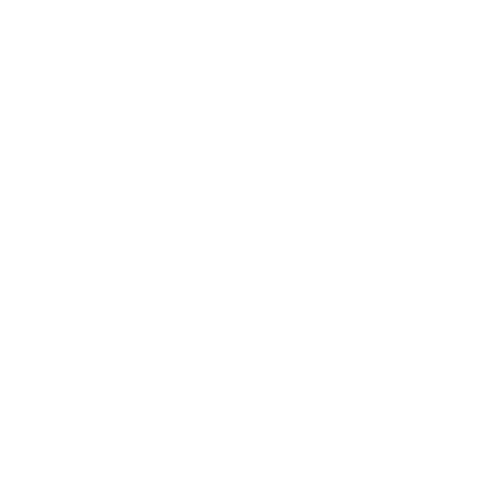



nfl - 19521 comments - 0.11643870703345116 sarcastic


<IPython.core.display.Javascript object>


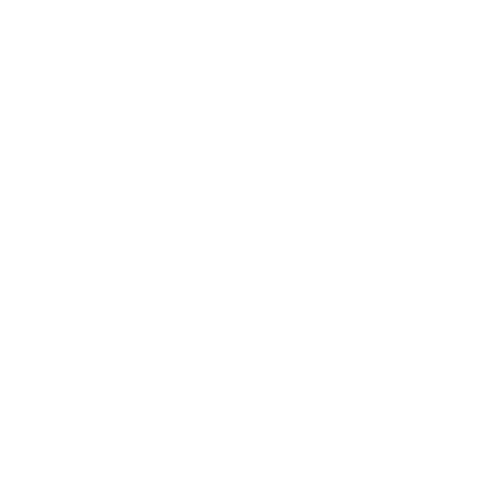

In [47]:
tsne = TSNE(n_components=2)
comment_topic_tsne_space = list()
all_sub_topics = list()

for arg in sub_args[:10]:
    sub = subs.get_group(subs_sorted[arg]).iloc[:5000]
    print(subs_sorted[arg], '-', subs_sizes[arg], 'comments -', np.sum(sub['label']) / subs_sizes[arg], 'sarcastic')
    
    sub_topics = list()
    for comment in sub['comment'].values:
        all_comment_topics = np.zeros(100)
        comment_topics = ldaModel[dictionary.doc2bow(tokenize(comment))]
        for topic in comment_topics:
            all_comment_topics[topic[0]] += topic[1]
            
        sub_topics.append(all_comment_topics)
    
    #print(np.mean(np.vstack(sub_topics), axis=0))
    sub_topics_cor = pd.DataFrame(data=sub_topics).corr()
    plt.matshow(sub_topics_cor, vmin=-1, vmax=1)
    plt.colorbar()
    
    for i in range(sub_topics_cor.shape[0]):
        if (np.all(np.isnan(sub_topics_cor[i]))):
            print("Missing topic {}:\n{}\n".format(i, ldaModel.print_topic(i)))
            
    print("\n")
    
    #comment_topic_tsne_space.append(tsne.fit_transform(sub_topics))
    all_sub_topics.append(np.vstack(sub_topics))

## Subreddit Topic TSNE

In [ ]:
plt.figure()
for i in range(len(comment_topic_tsne_space)):
    arg = sub_args[i]
    plt.scatter(comment_topic_tsne_space[i][:, 0], comment_topic_tsne_space[i][:, 1], alpha=0.3, label=subs_sorted[arg])
plt.legend()
plt.title('Topics Grouped by Subreddit (TSNE seperate)')

In [ ]:
sub_lengths = list()
for i in range(len(all_sub_topics)):
    sub_lengths.append(len(all_sub_topics[i]))
    
all_sub_tsne = tsne.fit_transform(np.vstack(all_sub_topics))

In [ ]:
plt.figure()
last_l = 0
sum_l = 0
for i, l in enumerate(sub_lengths):
    arg = sub_args[i]
    sum_l += l
    plt.scatter(all_sub_tsne[last_l:sum_l, 0], all_sub_tsne[last_l:sum_l, 1], alpha=0.3, label=subs_sorted[arg])
    last_l = sum_l
plt.legend()
plt.title('Topics Grouped by Subreddit (TSNE together)')

## Subreddit Topic Distribution

AskReddit - 88439 comments - 0.39942785422720745 sarcastic


<IPython.core.display.Javascript object>


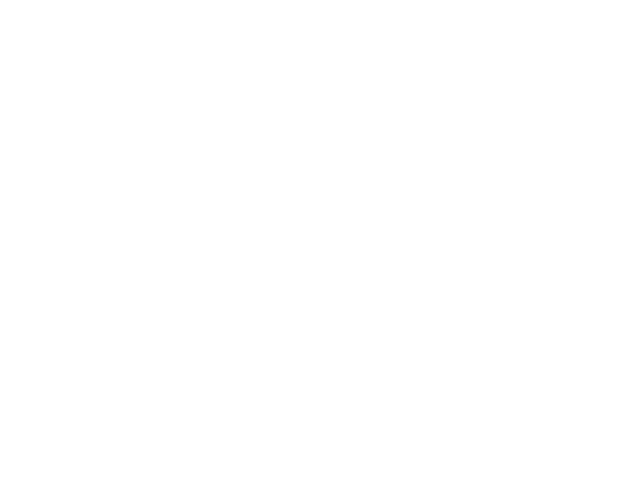

Top Topics:
0.190*"everi" + 0.116*"sinc" + 0.086*"joke" + 0.060*"polic" + 0.059*"answer" + 0.053*"sourc" + 0.052*"that" + 0.046*"enjoy" + 0.041*"race" + 0.038*"page"

0.137*"believ" + 0.125*"true" + 0.121*"last" + 0.109*"word" + 0.101*"fun" + 0.070*"lie" + 0.047*"male" + 0.043*"told" + 0.029*"sub" + 0.028*"expens"

0.636*"like" + 0.070*"sound" + 0.033*"dog" + 0.026*"attack" + 0.026*"yup" + 0.018*"victim" + 0.017*"heart" + 0.014*"blood" + 0.014*"critic" + 0.011*"statist"

politics - 58803 comments - 0.6072309235923338 sarcastic


<IPython.core.display.Javascript object>


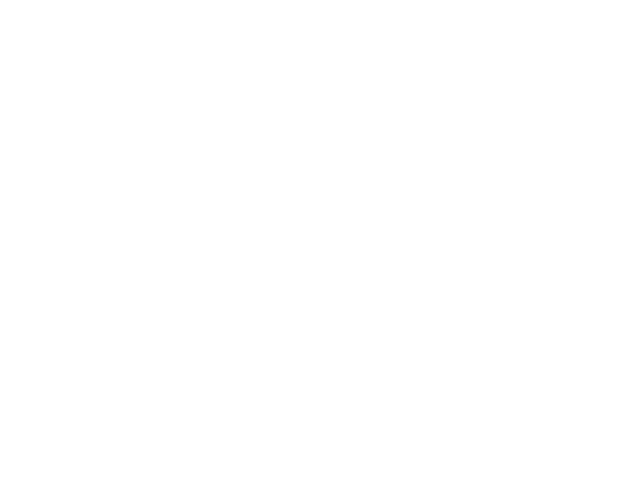

Top Topics:
0.190*"everi" + 0.116*"sinc" + 0.086*"joke" + 0.060*"polic" + 0.059*"answer" + 0.053*"sourc" + 0.052*"that" + 0.046*"enjoy" + 0.041*"race" + 0.038*"page"

0.224*"day" + 0.160*"kid" + 0.085*"yet" + 0.074*"head" + 0.070*"liber" + 0.068*"100" + 0.061*"becom" + 0.057*"happi" + 0.031*"lack" + 0.027*"stick"

0.395*"go" + 0.133*"back" + 0.079*"big" + 0.064*"win" + 0.060*"cool" + 0.053*"ok" + 0.035*"fire" + 0.034*"boy" + 0.034*"babi" + 0.027*"posit"

worldnews - 34929 comments - 0.6444215408399897 sarcastic


<IPython.core.display.Javascript object>


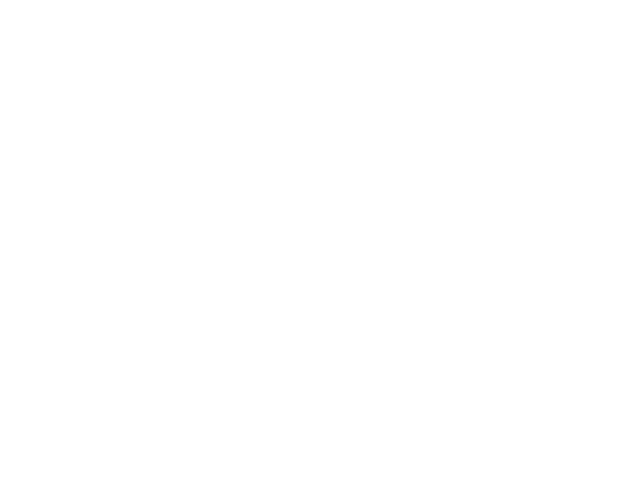

Top Topics:
0.190*"everi" + 0.116*"sinc" + 0.086*"joke" + 0.060*"polic" + 0.059*"answer" + 0.053*"sourc" + 0.052*"that" + 0.046*"enjoy" + 0.041*"race" + 0.038*"page"

0.305*"us" + 0.182*"mayb" + 0.124*"funni" + 0.038*"prefer" + 0.032*"larg" + 0.030*"student" + 0.026*"citizen" + 0.026*"driver" + 0.022*"father" + 0.021*"intern"

0.597*"yeah" + 0.102*"live" + 0.059*"place" + 0.054*"tax" + 0.022*"current" + 0.020*"bullshit" + 0.020*"canada" + 0.015*"match" + 0.014*"honest" + 0.014*"retard"

leagueoflegends - 26585 comments - 0.5439157419597518 sarcastic


<IPython.core.display.Javascript object>


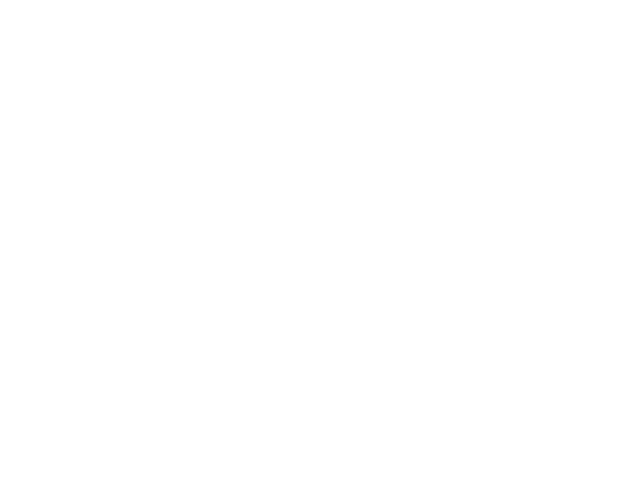

Top Topics:
0.190*"everi" + 0.116*"sinc" + 0.086*"joke" + 0.060*"polic" + 0.059*"answer" + 0.053*"sourc" + 0.052*"that" + 0.046*"enjoy" + 0.041*"race" + 0.038*"page"

0.224*"day" + 0.160*"kid" + 0.085*"yet" + 0.074*"head" + 0.070*"liber" + 0.068*"100" + 0.061*"becom" + 0.057*"happi" + 0.031*"lack" + 0.027*"stick"

0.261*"better" + 0.220*"play" + 0.102*"lol" + 0.071*"christian" + 0.050*"close" + 0.049*"ad" + 0.028*"11" + 0.027*"gave" + 0.025*"judg" + 0.022*"impress"

pcmasterrace - 24467 comments - 0.5698696203049005 sarcastic


<IPython.core.display.Javascript object>


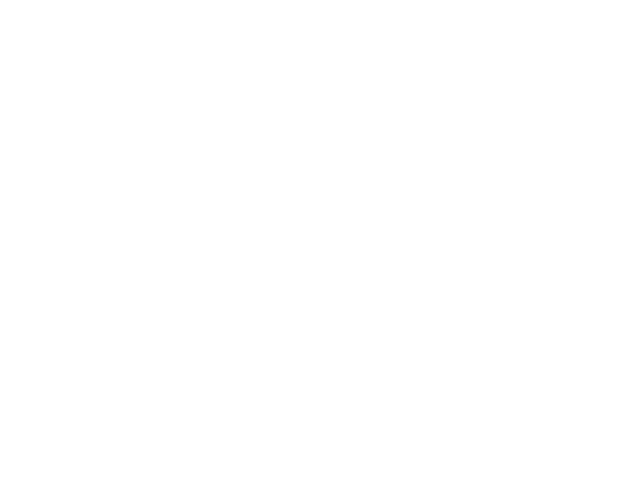

Top Topics:
0.190*"everi" + 0.116*"sinc" + 0.086*"joke" + 0.060*"polic" + 0.059*"answer" + 0.053*"sourc" + 0.052*"that" + 0.046*"enjoy" + 0.041*"race" + 0.038*"page"

0.636*"like" + 0.070*"sound" + 0.033*"dog" + 0.026*"attack" + 0.026*"yup" + 0.018*"victim" + 0.017*"heart" + 0.014*"blood" + 0.014*"critic" + 0.011*"statist"

0.179*"man" + 0.147*"thank" + 0.139*"tri" + 0.127*"still" + 0.080*"white" + 0.071*"hard" + 0.067*"hey" + 0.036*"til" + 0.029*"amaz" + 0.025*"refer"

news - 23142 comments - 0.6017198167833376 sarcastic


<IPython.core.display.Javascript object>


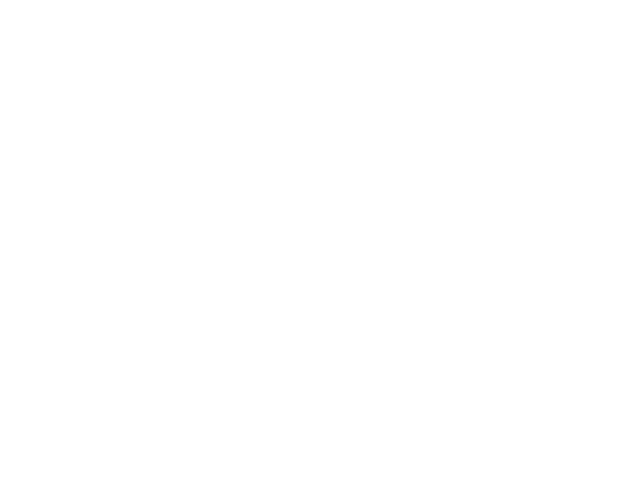

Top Topics:
0.190*"everi" + 0.116*"sinc" + 0.086*"joke" + 0.060*"polic" + 0.059*"answer" + 0.053*"sourc" + 0.052*"that" + 0.046*"enjoy" + 0.041*"race" + 0.038*"page"

0.224*"day" + 0.160*"kid" + 0.085*"yet" + 0.074*"head" + 0.070*"liber" + 0.068*"100" + 0.061*"becom" + 0.057*"happi" + 0.031*"lack" + 0.027*"stick"

0.597*"yeah" + 0.102*"live" + 0.059*"place" + 0.054*"tax" + 0.022*"current" + 0.020*"bullshit" + 0.020*"canada" + 0.015*"match" + 0.014*"honest" + 0.014*"retard"

funny - 22890 comments - 0.44945391000436874 sarcastic


<IPython.core.display.Javascript object>


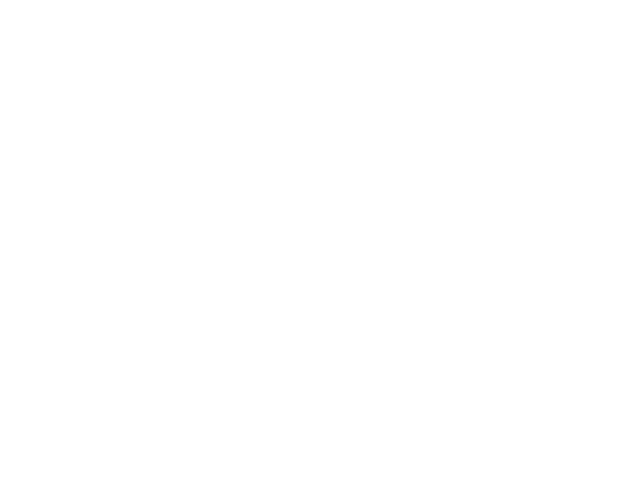

Top Topics:
0.190*"everi" + 0.116*"sinc" + 0.086*"joke" + 0.060*"polic" + 0.059*"answer" + 0.053*"sourc" + 0.052*"that" + 0.046*"enjoy" + 0.041*"race" + 0.038*"page"

0.224*"day" + 0.160*"kid" + 0.085*"yet" + 0.074*"head" + 0.070*"liber" + 0.068*"100" + 0.061*"becom" + 0.057*"happi" + 0.031*"lack" + 0.027*"stick"

0.636*"like" + 0.070*"sound" + 0.033*"dog" + 0.026*"attack" + 0.026*"yup" + 0.018*"victim" + 0.017*"heart" + 0.014*"blood" + 0.014*"critic" + 0.011*"statist"

pics - 21104 comments - 0.4944560272934041 sarcastic


<IPython.core.display.Javascript object>


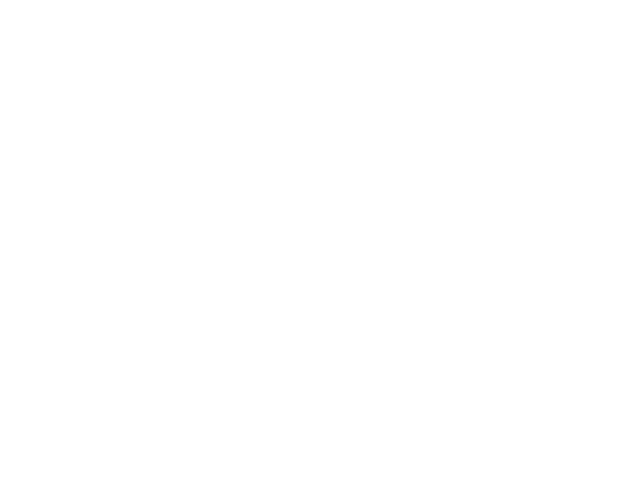

Top Topics:
0.190*"everi" + 0.116*"sinc" + 0.086*"joke" + 0.060*"polic" + 0.059*"answer" + 0.053*"sourc" + 0.052*"that" + 0.046*"enjoy" + 0.041*"race" + 0.038*"page"

0.224*"day" + 0.160*"kid" + 0.085*"yet" + 0.074*"head" + 0.070*"liber" + 0.068*"100" + 0.061*"becom" + 0.057*"happi" + 0.031*"lack" + 0.027*"stick"

0.636*"like" + 0.070*"sound" + 0.033*"dog" + 0.026*"attack" + 0.026*"yup" + 0.018*"victim" + 0.017*"heart" + 0.014*"blood" + 0.014*"critic" + 0.011*"statist"

nba - 20779 comments - 0.5162904855864093 sarcastic


<IPython.core.display.Javascript object>


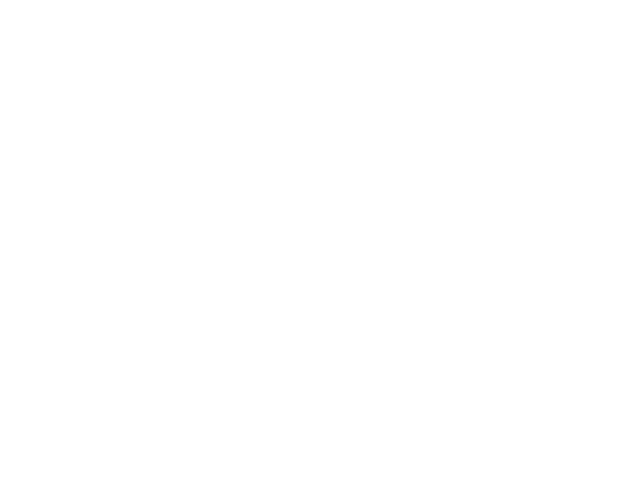

Top Topics:
0.224*"day" + 0.160*"kid" + 0.085*"yet" + 0.074*"head" + 0.070*"liber" + 0.068*"100" + 0.061*"becom" + 0.057*"happi" + 0.031*"lack" + 0.027*"stick"

0.190*"everi" + 0.116*"sinc" + 0.086*"joke" + 0.060*"polic" + 0.059*"answer" + 0.053*"sourc" + 0.052*"that" + 0.046*"enjoy" + 0.041*"race" + 0.038*"page"

0.261*"better" + 0.220*"play" + 0.102*"lol" + 0.071*"christian" + 0.050*"close" + 0.049*"ad" + 0.028*"11" + 0.027*"gave" + 0.025*"judg" + 0.022*"impress"

nfl - 19521 comments - 0.5054556631320117 sarcastic


/home/dominic/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


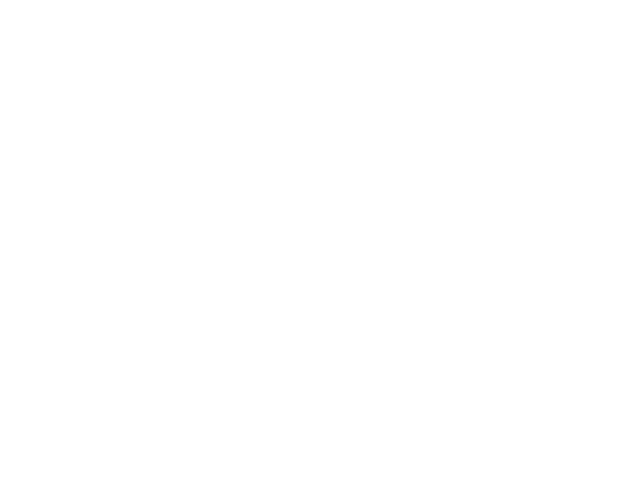

Top Topics:
0.224*"day" + 0.160*"kid" + 0.085*"yet" + 0.074*"head" + 0.070*"liber" + 0.068*"100" + 0.061*"becom" + 0.057*"happi" + 0.031*"lack" + 0.027*"stick"

0.190*"everi" + 0.116*"sinc" + 0.086*"joke" + 0.060*"polic" + 0.059*"answer" + 0.053*"sourc" + 0.052*"that" + 0.046*"enjoy" + 0.041*"race" + 0.038*"page"

0.305*"us" + 0.182*"mayb" + 0.124*"funni" + 0.038*"prefer" + 0.032*"larg" + 0.030*"student" + 0.026*"citizen" + 0.026*"driver" + 0.022*"father" + 0.021*"intern"



In [48]:
for arg in sub_args[:10]:
    sub = subs.get_group(subs_sorted[arg])
    print(subs_sorted[arg], '-', subs_sizes[arg], 'comments -', np.sum(sub['label']) / subs_sizes[arg], 'sarcastic')
    
    sub_topics = list()
    for comment in sub['comment'].values:
        all_comment_topics = np.zeros(100)
        comment_topics = ldaModel[dictionary.doc2bow(tokenize(comment))]
        for topic in comment_topics:
            all_comment_topics[topic[0]] += topic[1]
            
        sub_topics.append(all_comment_topics)
        
    topic_dist = np.mean(np.vstack(sub_topics), axis=0)
    topic_args = np.argsort(topic_dist)
    
    plt.figure()
    plt.bar(range(100), topic_dist[topic_args])
    plt.xlabel("Topic")
    plt.title("r/{} Topic Distribution".format(subs_sorted[arg]))
    plt.tight_layout()
    
    print("Top Topics:")
    for i in range(1, 4):
        print(ldaModel.print_topic(topic_args[-i]))
        print()

## Main Model on Different Subreddits

In [ ]:
for arg in sub_args[:10]:
    sub = subs.get_group(subs_sorted[arg])
    print(subs_sorted[arg], '-', subs_sizes[arg], 'comments -', np.sum(sub['label']) / subs_sizes[arg], 'sarcastic')
    sub_docs = feature_extractor.transform(sub)
    eval_summary("r/{}".format(subs_sorted[arg]), main_clf.predict(sub_docs), sub['label'])

# Just Looking at Results

In [103]:
lr_clf = LogisticRegression()
lr_clf.fit(feature_train, train['label'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [104]:
print("Label / Predicted_Label / Sarcasm_Probability - r/subreddit - u/user")
print("  - Parent Comment")
print("  - Analyzed Comment\n")

i = 0
for _, post in test.iloc[:20].iterrows():
    print("{} / {} ({}) - r/{} - u/{}".format(post['label'], lr_clf.predict(feature_space[i])[0], lr_clf.predict_proba(feature_space[i])[0][1], post['subreddit'], post['author']))
    #print(post['label'], "/", main_clf.predict(feature_space[i]), "-", post['subreddit'], "-", post['author'])
    print("  -", post['parent_comment'])
    print("  -", post['comment'])
    i += 1

Label / Predicted_Label / Sarcasm_Probability - r/subreddit - u/user
  - Parent Comment
  - Analyzed Comment

0 / 0 (0.36209756154755074) - r/FoodPorn - u/no1z
  - Or sandwich it with butter and mayo
  - Now you're thinking with portals.
0 / 0 (0.3926824241443938) - r/fivenightsatfreddys - u/Exotic_purple_guy
  - officer
  - Dunn
0 / 1 (0.7004357079747453) - r/Fitness - u/Hyabusa2
  - Went to the gym at 3 in the morning Monday and was one of about 8 other people in the weight area. 3 of the guys there were using 4 of the ez-bars (50lbs-90lbs) and some dumbells all scattered around there area. They decide to take their shirts off while they're working out. After some lifting and flexing, they fucking leave. Leave all of the shit they were using all over the place. I couldn't believe it. I feel like when you spend enough time in the gym you start treating it with some respect. It pissed me off so much, I just put all of their shit back myself.
  - Bro, just think of all the gainz you get

In [113]:
i = 0
for _, row in train[train['label'] == 1].iterrows():
    if ("racism" in row['comment'] or "racist" in row['comment']):
        print("r/{} - u/{}".format(row['subreddit'], row['author']))
        print("\t- {}".format(row['parent_comment']))
        print("\t- {} /s [{}]".format(row['comment'], row['score']))
        
        i += 1

r/Overwatch - u/The_cuckmaker
	- Of course the Mexican is the sneaky flanker that beats barriers
	- Your casual racism is funny. /s [1]
r/politics - u/Grammer_NotZ
	- Poor people in the United States should be grateful they're here and not in the third world. In addition to exceptionally generous social welfare programs for a national government of limited authority, they are blessed to live in a stable, peaceful republic with an abundance of opportunities to work hard and prosper. No child in the United States who wants to escape poverty is stuck there. There are many ways to escape destitution that are unimaginable in other places. The United States is a fantastic country.
	- That's racist! /s [-1]
r/SquaredCircle - u/BestInTheEU
	- It's a good thing Goldberg is tall or I wouldn't be able to tell them apart. Bald white dudes all look the same to me
	- Wow, racist /s [-2]
r/GunsAreCool - u/fitzroy95
	- Here's What Happens When a Black Man Open Carries Gun
	- Good thing the police aren

	- SRS much? Yuck.
	- Because only SRS is anti-racism... /s [3]
r/news - u/Roody2003
	- Why is it that we rarely hear about Chinese or Japanese or European 2nd generations forming gangs and breaking the law.
	- But... All cultures are equal and everyone has the same abilities.... It must be because of bigotry and racism..... /s [6]
r/CollegeBasketball - u/boondog13
	- It's a racist word. Anyone who uses it should be shamed.
	- Yup Harrison should be shamed for being racist against black people /s [-7]
r/thatHappened - u/Capn__Morgan
	- and spammed racist comments towards perceived oppressors.
	- But racism = prejudice + power, minorities can't be racist! /s [20]
r/CringeAnarchy - u/PM_ME_MEMES_PLZ
	- Isnt this kind of half the reason police are heavy handed and paranoid in the first place?
	- no you white cis scum it's because they're racist! /s [13]
r/Libertarian - u/Nation_On_Fire
	- Eat shit, you statist pig-fuck.
	- Oh joy, they let your racist ass back out of the mental institutio

In [127]:
sarc_count = 0
non_sarc_count = 0

for _, row in train.iterrows():
    if ("?" in row['comment']):
        if (row['label'] == 1):
            sarc_count += 1
        else:
            non_sarc_count += 1
        
print("Sarcatic questions: {} / {}".format(sarc_count, train[train['label'] == 1].shape[0]))
print("Non-sarcatic questions: {} / {}".format(non_sarc_count, train[train['label'] == 0].shape[0]))

Sarcatic questions: 583 / 5000
Non-sarcatic questions: 630 / 5000


In [128]:
sarc_count = 0
non_sarc_count = 0

for _, row in train.iterrows():
    if (" or " in row['comment']):
        if (row['label'] == 1):
            sarc_count += 1
        else:
            non_sarc_count += 1
        
print("Sarcatic 'or': {} / {}".format(sarc_count, train[train['label'] == 1].shape[0]))
print("Non-sarcatic 'or': {} / {}".format(non_sarc_count, train[train['label'] == 0].shape[0]))

Sarcatic 'or': 94 / 5000
Non-sarcatic 'or': 170 / 5000


In [48]:
i = 0
for _, post in train.iterrows():
    if ("forgot" in post['comment']):
        print("r/{} - u/{}".format(post['subreddit'], post['author']))
        print("\t- {}".format(post['parent_comment']))
        print("\t- {} /s".format(post['comment']))
        i += 1
    if (i >= 20):
        break

r/reddevils - u/androidenthusiast08
	- Yes I'm sure that's it. Mourinho S forgotten to practice finishing
	- haha not saying completely forgot but more 1 or 1s or something /s
r/thatHappened - u/maybesaydie
	- I am on so many drugs
	- You forgot the picture. /s
r/AskReddit - u/Enroberman
	- Legalise guns again so we can shoot up schools
	- You forgot this /s
r/BeAmazed - u/_Fresh_
	- Mildlyinfuriating Fixed.
	- They forgot to fix the way they spelled "center," that's just not right /s
r/videos - u/Th3BlackLotus
	- "As you can see this comment is very volatile and dangerous. Call him a faggot, reeeeeeeeeeee!, click 'save', spin and turn your fedora and boom - you're out."
	- You forgot the snapping 10 times to get your attention. /s
r/nba - u/DumbestAsian
	- Let's do it again: Boo that you ungrateful fucks. This kind of fucking shit and all the fucking tanking threads is why no one wants to fucking play in New York. Why don't you useless pieces of fucking East River garbage boat dump tr

In [49]:
print(train_balanced.shape[0], test_balanced.shape[0])

1125678 283334


In [50]:
import sys

In [51]:
sys.getsizeof(train_balanced)

653267319